#Santiago Juan Marco B. #COE 005-ECE41S11

# Playing Mario with Deep Reinforcement Learning

We will be training an AI to play the game Mario

In [31]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Finished installing the necessary libraries

Import the libraries needed

In [32]:
import io
import os 
import gym
import base64
from gym import wrappers
from IPython.display import HTML
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import gym_super_mario_bros
from google.colab import drive
from nes_py.wrappers import JoypadSpace
from IPython import display as ipythondisplay
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [34]:
COMPLEX_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left'],
 ['left', 'A'],
 ['left', 'B'],
 ['left', 'A', 'B'],
 ['down'],
 ['up']]

# Mount your Google Drive Directory

In [35]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setup game environment "SuparMarioBros-v1"

In [36]:
#Game setup
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [37]:
env.action_space

Discrete(12)

In [38]:
#Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [39]:
state = env.reset()

In [40]:
state, reward, done, info = env.step([5])

#Visualization of the Environment

This will show the interface environment of the game

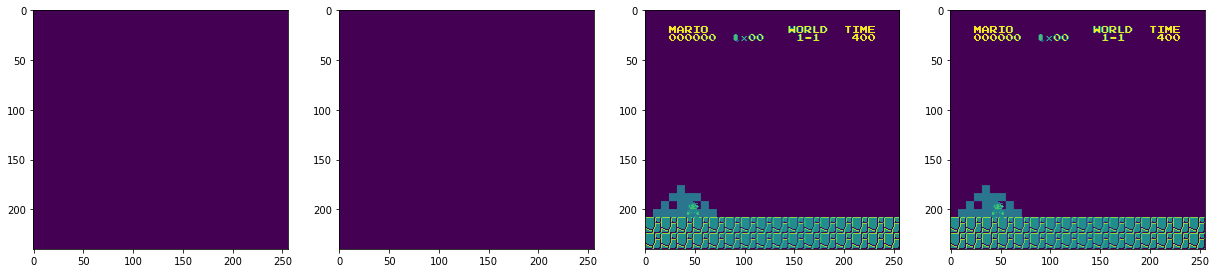

In [41]:
plt.figure(figsize=(21,17))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [42]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'test_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [43]:
CHECKPOINT_DIR = 'train'
LOG_DIR = 'logs'

In [44]:
#Model saving every 50000 timesteps
callback = TrainAndLoggingCallback(check_freq=50000, save_path=CHECKPOINT_DIR)

In [45]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


# TRAINING THE MODEL

The higher the timesteps set, the more time the AI will learn how to play the game

In [46]:
#Train the model
model.learn(total_timesteps=100000, callback=callback)

Logging to logs/PPO_3
----------------------------
| time/              |     |
|    fps             | 104 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.017723078 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.000638    |
|    learning_rate        | 0.0001      |
|    loss                 | 4.13        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 15.4        |
-----------------------------------------
-------------------

### SAVE THE MODEL

In [47]:
model.save('testmodel')

In [48]:
#Load model
model = PPO.load('testmodel')

### VIRTUAL ENVIRONMENT SETUP

In [49]:
#Game setup
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = wrappers.Monitor(env, "./videos", force=True)
env.reset()
for _ in range(5000):
  state, reward, done, info = env.step(env.action_space.sample())
  if done: break
env.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


### VIDEO PLAYBACK

This will show the video footage on how the AI perform to this game

In [50]:
video = io.open('./videos/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="480" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))